# <span style="color:green"> Environmental Sound Classification </span>
## <span style="color:green">Notebook 2: Features Classification </span>

---
[Mattia Pujatti](mattia.pujatti.1@studenti.unipd.it), ID 1232236, master degree in Physics of Data

---

This notebook has been realized as final project for the course of Human Data Analytics, held by professors [Michele Rossi](rossi@dei.unipd.it) and [Francesca Meneghello](meneghello@dei.unipd.it), during the academic year 2019/2020 at the University of Padua.

### Table of Content

1. #### [Introduction](#Introduction-to-Notebook-2) 
2. #### [Datasets Presentation](#Datasets-Comparison)
3. #### [Setup of the Classification](#Clips-Classification)
4. #### [Canonical Classifiers from SKLearn](#Machine-Learning-Models)
    * #### [Principal Component Analysis](#Impact-of-the-dimensionality-reduction)
    * #### [Representing features distributions](#Importance-of-the-statistical-estimators-of-the-features-distributions)
    * #### [Impact of the Silence Removal](#Importance-of-the-silence-removal-step)
5. #### [Using a Feed-Forward Neural Network](#Overfitting)
    * #### [Augmentation](#Data-Augmentation)
6. #### [Best Case Analysis](#Best-case-deeper-Analysis)
7. #### [Final Comparison](#Comprehensive-recap-of-all-the-results)

## Project Presentation

*The main purpose of this notebook will be to provide an efficient way, using machine learning techniques, to classify environmental sound clips belonging to one of the only public available dataset on the internet. <br>
Several approaches have been tested during the years, but only a few of them were able to reproduce or even overcome the human classification accuracy, that was estimated around 81.30%. <br>
The analysis will be organized in the following way: since the very first approaches were maily focused on the examination of audio features that one could extract from raw audio files, we will provide a way to collect and organize all those "vector of features" and use them to distinguish among different classes. Then, different classification architectures and techniques will be implemented and compared among each other, in order also to show how they react to different data manipulation (overfitting, numerical stability,...). <br>
In the end, it will be shown that all those feature classifiers, without exceptions, underperform when compared to the results provided by the use of Convolutional Neural Networks directly on audio signals and relative spectrograms (so without any kind of feature extraction), and how this new approach opened for a large number of opportunities in term of models with high accuracy in sound classification.*

### Summary of Notebook 1

In the first [notebook](https://github.com/MattiaPujatti/Environmental-Sound-Classification/blob/master/Analysis_of_Sound_Features.ipynb) we presented the __ESC-50 dataset__, a labeled collection of 2000 audio recordings divided into 50 classes and collected by [Karol Piczak](https://github.com/karolpiczak/ESC-50). We loaded the dataset and, thank to several functions provided by the library _librosa_, we were able to extract from them 55 different _features per frame_, with the purpose of using such distributions to construct vectors of features to give in input to a machine learning classifier. We examined and studied the clips via their time signal, via their spectrogram and also how it looked in the Mel scale. Moreover, we gave a look at some particular distributions for specific clips that used to show an irregular behavior, and for them we dispensed a way to approximate and describe such features with a statistical approach. We also examined the problem of having short signals and the consequent impact of longs period of silence inside the clips, and to face up to this we developed a further apparently working preprocessing step. In the end, we also provided a data augmentation procedure to help us dealing with such scarse amount of data.

## Introduction to Notebook 2

*In this second notebook we opted for the simplest approach of taking several "canonical" classifiers, provided by sklearn, and running on them a cross-validation to train and verify their effective accuracy in this classification problem. The datasets have been generated in the previous notebook and basically constist in collections of clips in the form of "vectors of features", such that every environmental sound in ESC50 can be identified by a sequence of float numbers. Moreover, several preprocessing steps implemented in the first notebook will find legitimacy and their efficacy will be proved directly on the data. In the end, we will see if the augmentation previously described is compatible with this features approach.*

---

As our main instrument for constructing and training Machine Learning models, with the purpose of classifying environmental sounds, will be __keras__, an highlevel API of the platform __tensorflow__. <br>
Just a quick technical remark: we will import all keras functions and objects via _tf.keras_, and not just via _keras_, because of some incompatibilities between the two modules.

In [1]:
# Requirements
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import seaborn as sns
import time
import warnings
sns.set_theme()
warnings.filterwarnings('ignore')

In [2]:
from tqdm.keras import TqdmCallback
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.multiclass import type_of_target

## Datasets Comparison

In the previous notebook we have created several _csv_ file containing all the vectors of features extracted from the audio files in the original dataset. We have already recalled, in the introduction, that for each clip we derived complessively 55 different features per frame, and in order to summarize those features we decide to take the mean and/or the standard deviation of the corresponding distributions. We also removed some silent parts in the calculation to have more "uniform" and consistent results, and, in the end, we augmented the data in order to have more available sounds. <br>
So we ended up with the following files:
* `features.csv`: uses mean and standard deviation to represent the features distributions and was corrected via silence removal with a window of 0.5 seconds.
* `features_nosilenceremoval.csv`: also this file uses both mean and std to represent features distribution but, as the name suggests, no silence removal was applied, mainly to show the effective improvement that this procedure guarantees.
* `reduced_features.csv`: differently from the first two, in this file only the mean of the features is reported; silence removal was instead correctly applied.
* `augmented_features.csv`: this file has been generated from the augmented data constructed applying to every clip in the original dataset 4 different augmentation procedures, resulting in a collection of clips five times bigger.

The following table summarize all the available data for classification.

| Filename | Features Length | Number of Clips | Silence Removal | Augmented |
| :--- | :--- | :--- | :--- | :--- |
| features.csv | 110 | 2000 | Yes | No |
| features_nosilenceremoval.csv | 110 | 2000 | No | No |
| reduced_features.csv | 55 | 2000 | Yes | No |
| augmented_features.csv | 110 | 10000 | Yes | Yes |

In [3]:
# Let's load the datasets
features = pd.read_csv(os.getcwd() + '/features_datasets/features.csv', index_col=0)
features_nosilenceremoval = pd.read_csv(os.getcwd() + '/features_datasets/features_nosilenceremoval.csv', index_col=0)
reduced_features = pd.read_csv(os.getcwd() + '/features_datasets/reduced_features.csv', index_col=0)
augmented_features = pd.read_csv(os.getcwd() + '/features_datasets/augmented_features.csv', index_col=0)
features

,0,1,2,3,4,5,6,7,8,9,...,102,103,104,105,106,107,108,109,label,clipname
0,273.927703,1168.622070,436.259698,2074.699983,255.475244,976.942865,0.007329,0.027503,0.007518,0.040822,...,0.721955,1.107690,0.435245,0.451013,0.538303,0.727118,0.500143,0.450082,dog,1-100032-A-0.wav
1,4043.327516,537.181203,6625.132097,631.124050,2645.356543,178.365557,0.157994,0.022784,0.048209,0.038197,...,1.279261,1.160237,0.748184,0.666160,0.725012,1.007626,0.584620,0.725929,chirping_birds,1-100038-A-14.wav
2,4410.473294,390.254843,8363.825837,569.020290,4051.233312,161.197379,0.199469,0.029614,0.271365,0.046708,...,0.522859,0.588512,0.512404,0.635812,0.576114,0.571322,0.597317,0.546289,vacuum_cleaner,1-100210-A-36.wav
3,4369.644056,224.081560,8418.533162,316.244594,3946.844138,111.435264,0.202079,0.021309,0.275260,0.066043,...,0.557757,0.521746,0.502744,0.488045,0.450892,0.565211,0.577689,0.526760,vacuum_cleaner,1-100210-B-36.wav
4,2075.696947,584.761524,4559.843116,1906.344111,3455.549264,500.923009,0.027574,0.010662,0.008845,0.006442,...,0.525161,0.514323,0.565485,0.554065,0.489864,0.528734,0.506565,0.558096,thunderstorm,1-101296-A-19.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1918.757528,303.783879,3106.227002,644.665288,2170.010452,434.008532,0.053308,0.018209,0.085123,0.087223,...,0.908361,1.263996,0.991909,0.835533,0.968926,0.802479,0.763298,0.794067,hen,5-263831-B-6.wav
1996,5685.663242,143.534391,11292.940994,253.468461,4396.309142,68.666402,0.227157,0.017203,0.119567,0.003821,...,0.487366,0.492283,0.451245,0.463138,0.476303,0.451795,0.511070,0.498505,vacuum_cleaner,5-263902-A-36.wav
1997,1931.486868,1329.795683,4316.632831,3188.653985,2824.456677,1655.568125,0.025522,0.025662,0.065660,0.094834,...,0.850813,0.775175,0.799110,0.885374,0.834324,0.756124,0.759324,0.636704,footsteps,5-51149-A-25.wav
1998,3503.472061,940.171052,7393.582670,3105.111474,3994.320503,921.695082,0.075558,0.021528,0.061051,0.040678,...,0.722414,0.723565,0.600105,0.629163,0.528401,0.590463,0.632595,0.592112,sheep,5-61635-A-8.wav


## Clips Classification

Following the same technique used also in the first notebook we will define a class to handle all the necessary steps to construct and train a machine learning model over our datasets. <br>
The class is supposed to work with a dataset formatted like the ones shown before, in which each line correspond to a vector of features while the last column contains the categorical label of the clip. More in practice, such data should be renormalized and their labels should be encoded in a format that is congenial to the machine learning classifiers. <br>
Moreover, the class is supposed to provide several functions to automatize the training process, the hyperparameter tuning and the final validation of the model. But there is a problem with 3 out of 4 of our datasets: they are composed just by 2000 clips, which is never enough to train properly a 50-classes classifier! We can't even talk about splitting the clips in a train-validation-test sets, because we won't have enough data to construct a significative statistics, and so we will rely on a technique (suggested also inside the same library _sklearn_) called __nested cross-validation__. A non-nested approach consists in using the same cross-validation procedure and data both to tune and select a model, but this is likely to lead to an optimistically biased evaluation of the model performance (because of  information leakage). Nested Cross-Validation (Nested-CV) nests cross-validation and hyperparameter tuning exploiting two different KFold (or stratified KFold) splitting, such that in the inner loop the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set; in the outer loop, instead, the generalization error is estimated by averaging test set scores over several dataset splits. <br>
Under this procedure, hyperparameter search does not have an opportunity to overfit the dataset as it is only exposed to a subset of the dataset provided by the outer cross-validation procedure. This reduces, if not eliminates, the risk of the search procedure overfitting the original dataset and should provide a less biased estimate of a tuned model’s performance on the dataset. Obviously, this does not come without any additional cost, since you dramatically increase the number of intermediate steps: if _n*k_ models are fit and evaluated as part of a traditional non-nested CV for a given model, then this number is increased to _k*n*k_ as the procedure is then performed _k_ more times for each fold in the outer loop of nested CV.

This is the internal structure of the class `ClipsClassifier`:

* `__init__`: the constructor of the class that takes in input a pandas dataframe, splitting features and labels;
* `Setup_Classifier`: function used to modify the default values chosen for some parameters/methods implemented by the class, like:

    * the number of components to keep after the Principal Component Analysis (default = all);
    * the number of folds to use in the cross validation (defualt = 5);
    * the verbosity of the messages printed;
    * the encoder method for the labels (LabelEncoder or OneHotEncoder, default = onehot).
    
* `_Create_Pipeline`: in order to simplify the features setup and training procedure we rely on a sklearn Pipeline containing a standardization function (StandardScaler), a dimensionality reduction step (PCA) and the model that we want to fit;
* `Run_Nested_Cross_Validation`: this function implement all the steps necessary to run a nested cross validation for our model over the initial dataset, fitting the pipeline and performing a GridSearch over the dictionary of hyperparameters provided; additionally, it will compute the effective performances via _cross-val-predict_ over the different folds and, if requested, compute also the confusion matrix;
* `Run_NonNested_Cross_Validation`: like _Run_Nested_Cross_Validation_, but with an initial split of the data into a training and a test set.

In [4]:
class ClipsClassifier():
    """The purpose of this class is to collect all the necessary steps and functions to construct a classification
    model for our clips. 
    In particular, all the necessary steps to prepare the input dataset for the training process will 
    be implemented:
    * standardization
    * PCA
    * Label Encoding
    * train test split or K-fold splitting
    Then a grid search can be run in order to test several combination of hyperparameters without constructing 
    directly a validation set. In the end, the performances will be shown in term of accuracy also over the
    different macro-categories to finally quantify the quality of the model constructed.
    """
    
    def __init__(self, dataset):
        """Initialize some global parameters.
        Dataset is a pandas dataframe with several "features" columns and one "label" column, 
        that contains the data that we want to fit."""
        
        self.dataset = dataset
        self.X = dataset.drop(['label', 'clipname'], axis=1)
        self.Y = dataset[['label']].to_numpy()     
        self.Setup_Classifier()
        
        self.setup_completed = False
        self.pipeline_fitted = False
        
        self.clf = None
        self.nested_scores = []
        self.final_accuracy = 0
        
        self.confusion_matrix = None
        
        
    def Setup_Classifier(self, pca_components=0.99, n_folds=5, n_jobs=-1, verbose=2, encoder_method='label'):
        """Change the value of some parameters/methods used during data pre-processing and training step."""
        
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.pca_components = pca_components
        self.n_folds = n_folds
        
        # Select the encoder for the labels
        if encoder_method == 'onehot':
            self.label_encoder = OneHotEncoder(sparse=False)
            self.Y = self.Y.reshape(-1,1)
        elif encoder_method == 'label':
            self.label_encoder = LabelEncoder()
        else:
            print('Invalid value of the encoder. Available: onehot, label')
            return 
        
        return self
    
    
    def _Create_Pipeline(self, model):
        """Construct a sklearn Pipeline that contains operations of standardization and
        dimensionality reduction."""
        
        return Pipeline([('standardization', StandardScaler()),
                         ('pca', PCA(n_components=self.pca_components, svd_solver='full')),
                         ('classifier', model)])
            
    
    def Run_Nested_Cross_Validation(self, model, parameters={}, compute_confusion_matrix=False):
        """To estimate the performances of a model with small amount of data, we will exploit 
        the "outer" K-fold splitting defined before, in order to compute the effective generalized 
        accuracy as the average of the validation values obtained among various folds. 
        Because of the stochastic nature of the approach, it may be better to repeat several times 
        the run to check if the results are compatible between themselves."""
        
        # Avoid calling cross validation more than once
        if self.pipeline_fitted:
            print('Cross validation alredy completed!')
            return
        
        # Define two KFold splitting
        inner_cv = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        outer_cv = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        # Standardize and eventually apply pca on the dataset
        pipeline = self._Create_Pipeline(model)
        
        # Encode the labels
        labels = self.label_encoder.fit_transform(self.Y)
        
        # StratifiedKFold does not support one-hot-encoding
        if type_of_target(labels) == 'multilabel-indicator': splitting_labels = np.argmax(labels, axis=1)
        else: splitting_labels = labels
        
        # Run the inner CV            
        self.clf = GridSearchCV(estimator=pipeline, param_grid=parameters, n_jobs=self.n_jobs,
                                verbose=self.verbose, cv=inner_cv.split(self.X, splitting_labels)).fit(self.X, labels)
        self.pipeline_fitted = True

        # Nested CV cross validation
        self.nested_scores = cross_val_score(self.clf.best_estimator_, X=self.X, y=labels, n_jobs=self.n_jobs, 
                                             verbose=self.verbose, cv=outer_cv.split(self.X, splitting_labels))
                
        if self.verbose > 1:
            print("Optimal set of hyperparameters: ")
            print(self.clf.best_params_)
                    
        # Validate the best model found over the outer CV
        self.final_accuracy = np.mean(self.nested_scores)
        if self.verbose > 0:
            print("Average final accuracy estimated: {}%".format(round(self.final_accuracy*100, 2)))  
            
        if compute_confusion_matrix:
            
            # Compute the predictions over the outer CV
            predictions = cross_val_predict(self.clf.best_estimator_, self.X, labels, 
                                            cv=outer_cv.split(self.X, splitting_labels))
            
            # Confusion matrix does not support one-hot encoding
            if type_of_target(predictions) == 'multilabel-indicator': predictions = np.argmax(predictions, axis=1)
            if type_of_target(labels)      == 'multilabel-indicator': labels = np.argmax(labels, axis=1)
                        
            self.confusion_matrix = confusion_matrix(labels, predictions)
            
        return        
    
    
    def Run_NonNested_Cross_Validation(self, model, val_set=None, parameters={}, test_size=0.2, compute_confusion_matrix=False):
        """When you have enough data to construct a training and a test set, a nested CV would be
        very unefficient, because now you are able to properly setup a set of completely unseen data.
        """
        
        # Avoid calling cross validation more than once
        if self.pipeline_fitted:
            print('Cross validation alredy completed!')
            return
        
        if val_set is None:
            # Split the dataset into training and test data
            X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size=test_size, 
                                                                shuffle=True, random_state=42)
        else:
            X_train, Y_train = self.X, self.Y
            X_test = val_set.drop(['label'], axis=1)
            Y_test = val_set[['label']].to_numpy() 
            
        
        # Standardize and eventually apply pca on the dataset
        pipeline = self._Create_Pipeline(model)
        
        # Encode the labels
        train_labels = self.label_encoder.fit_transform(Y_train)
        test_labels = self.label_encoder.transform(Y_test)
        
        
        # Non_nested parameter search and scoring
        self.clf = GridSearchCV(estimator=pipeline, param_grid=parameters, n_jobs=self.n_jobs, 
                           verbose=self.verbose, cv=self.n_folds).fit(X_train, train_labels)
        
        self.pipeline_fitted = True
        
        # Return the optimal set of hyperparameters tuned
        if self.verbose > 1:
            print("Optimal set of hyperparameters: ")
            print(self.clf.best_params_)
        
        # Validate the best model found over the test set
        self.final_accuracy = self.clf.score(X_test, test_labels)
        if self.verbose > 0:
            print("Average final accuracy estimated: {}%".format(round(self.final_accuracy*100, 2)))  
            
        if compute_confusion_matrix:
            
            # Compute the predictions over the test set
            predictions = self.clf.predict(X_test)

            # Confusion matrix does not support one-hot encoding
            if type_of_target(predictions) == 'multilabel-indicator': predictions = np.argmax(predictions, axis=1)
            if type_of_target(test_labels) == 'multilabel-indicator': test_labels = np.argmax(test_labels, axis=1)

            self.confusion_matrix = confusion_matrix(test_labels, predictions)
            
        return

Now that we have a class that handle all the necessary information to train a model, it's time to start figuring out how can we effectively model our dataset and how different "canonical" classifiers work on them. In particular, in the next section we will train and study 4 different models provided by _sklearn_:
* a __Random Forest__
* a __Multi-Layer Perceptron__
* a __KNeighbors Classifier__
* a __Support Vector Machine__

## Machine Learning Models

First of all, let's define some reasonable set of parameters that our classifiers can take, that we will properly tune, writing them as dictionaries. Remeber that we are not performing the GridSearch directly on the models but on the pipelines, and so the keys of the dictionaries have to take into account the right *step_name* parameter.

In [5]:
# GridSearch for a Random Forest
params_RF = {'classifier__n_estimators': [250, 500],
             'classifier__bootstrap': [True, False],
             'classifier__max_depth': [5, 15, 20]}

# GridSearch for a Multi-Layer Perceptron
params_MLP = {'classifier__hidden_layer_sizes':[256, 512],
              'classifier__activation':['logistic', 'relu'],
              'classifier__solver':['sgd', 'adam'],
              'classifier__learning_rate_init':[0.01, 0.001]}

# GridSearch for a KNeighbors Classifier
params_KNC = {'classifier__n_neighbors':[2,5,8,10],
              'classifier__weights':['uniform', 'distance'],
              'classifier__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'classifier__leaf_size':[10, 30, 50, 100]}

# GridSearch for a Support Vector Machine
params_SVM = {'classifier__C':[0.1, 0.5, 1],
              'classifier__kernel':['linear', 'poly', 'rbf', 'sigmoid']}

In [5]:
# Since performing a nested CV over several sets of hyperparameters can be very time and resource consuming, you
# can just run it over the following reasonable combinations:

params_RF = {'classifier__n_estimators': [500], 'classifier__bootstrap': [False], 'classifier__max_depth': [20]}

params_MLP = {'classifier__hidden_layer_sizes': [512], 'classifier__activation': ['relu'], 
              'classifier__solver': ['adam'], 'classifier__learning_rate_init':[ 0.001]}

params_KNC = {'classifier__n_neighbors': [2], 'classifier__weights': ['distance'], 
              'classifier__algorithm': ['auto'], 'classifier__leaf_size': [10]}

params_SVM = {'classifier__C': [0.1], 'classifier__kernel':['linear']}

In [6]:
# Training a random forest can be quite memory demanding, and using all the cores (parameter n_jobs) can
# result in a notebook crash
rf_cc = ClipsClassifier(dataset = features)
rf_cc.Run_Nested_Cross_Validation(model = RandomForestClassifier(), parameters = params_RF, compute_confusion_matrix=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.7s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.7s finished


Optimal set of hyperparameters: 
{'classifier__bootstrap': False, 'classifier__max_depth': 20, 'classifier__n_estimators': 500}
Average final accuracy estimated: 59.0%


In [7]:
mlp_cc = ClipsClassifier(dataset = features)
mlp_cc.Run_Nested_Cross_Validation(model = MLPClassifier(), parameters = params_MLP, compute_confusion_matrix=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.5s remaining:   14.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


Optimal set of hyperparameters: 
{'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': 512, 'classifier__learning_rate_init': 0.001, 'classifier__solver': 'adam'}
Average final accuracy estimated: 67.55%


In [8]:
knc_cc = ClipsClassifier(dataset = features)
knc_cc.Run_Nested_Cross_Validation(model = KNeighborsClassifier(), parameters = params_KNC, compute_confusion_matrix=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Optimal set of hyperparameters: 
{'classifier__algorithm': 'auto', 'classifier__leaf_size': 10, 'classifier__n_neighbors': 2, 'classifier__weights': 'distance'}
Average final accuracy estimated: 51.65%


In [9]:
svm_cc = ClipsClassifier(dataset = features)
svm_cc.Run_Nested_Cross_Validation(model = SVC(), parameters = params_SVM, compute_confusion_matrix=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Optimal set of hyperparameters: 
{'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Average final accuracy estimated: 63.6%


Scores of the models over the cross validation folds:


,RF,MLP,KNC,SVM
0,0.6075,0.6825,0.5400,0.65
1,0.5575,0.6725,0.4875,0.62
2,0.5900,0.6700,0.4975,0.67
3,0.6025,0.6550,0.5450,0.64
4,0.5925,0.6975,0.5125,0.60


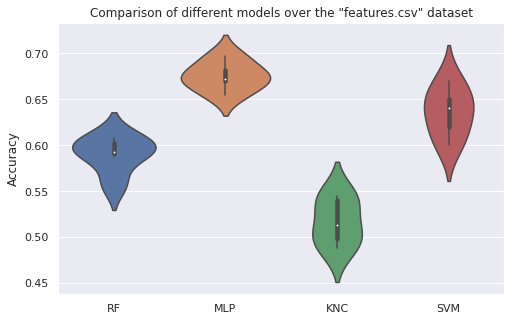

In [10]:
features_accuracies_df = pd.DataFrame()
features_accuracies_df['RF']  =  rf_cc.nested_scores
features_accuracies_df['MLP'] = mlp_cc.nested_scores
features_accuracies_df['KNC'] = knc_cc.nested_scores
features_accuracies_df['SVM'] = svm_cc.nested_scores
print('Scores of the models over the cross validation folds:')
display(features_accuracies_df)

fig, ax = plt.subplots(1, 1, figsize=(8,5))
sns.violinplot(data=features_accuracies_df, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of different models over the "features.csv" dataset');

In [11]:
# Saving the final results
esc50_final_models = {'RF'  : rf_cc,  'MLP' : mlp_cc, 'KNC' : knc_cc, 'SVM' : svm_cc}

So from this first analysis over the dataset _features.csv_ we obtain quite good results: getting an average accuracy above the 50% with just 2000 clips for 50 different classes and classifiers that are not even complicated is a nice starting point for our work. Moreover, what we can say is that the top performers found after several run of the previous analysis are the Multi-Layer Perceptron and the Support Vector Machine, with a final accuracy that exceeds the 60%. Random Forests reach intermediate results, but, as we will see also later on, are also by far the model that necessitate of the biggest amount of time to be trained, and so they are probably the least adapted classifier for this kind of tasks. In the end we have the KNeighbor Classifiers, with an accuracy just over the threshold of the 50%, but with a more reasonable training time. <br>
For a deeper analysis one could check, for example, directly the confusion matrices of the 4 classifiers, maybe to check if they behave similarly for different classes, or there is one performing better in a particular field respect to the others and so on. Moreover, one could also study the performances over the larger macro-categories, simply re-mapping the labels stored in the last column of the dataframe, to check how much such models are able to distinguish at least among those macro areas. But this notebook is not going through it for now, since it would make this analysis too much long and boring, and maybe it's better to guarantee such deeper controls only to the classifier that in the end will turn out to be the best.

One could also show that, on average, the scores calculated with the nested cross validation are all slightly bigger than the ones obtained with a non-nested approach: this means, as expected, that we are effectively reducing the overfitting and the information leakage between the train and validation sets. <br>
But, according to the methods that we have applied, are we sure that the statistics found, with such a small amount of data, is credible? Later on we will see that it effectively is, but for the moment we will keep what we obtain as a qualitative result.

We have left some open questions or, better, some statements that have not been proved yet, in the first notebook. Now we will go one-by-one through them with the purpose of providing at least a qualitative answer on the fact that a technique/procedure is better than another, justifying also many of the choices made previously in the analysis.

### Impact of the dimensionality reduction 

Working with large sized vectors of features could be very memory and time demanding, especially when training a complex classifier, maybe with a big number of parameters. For this reason one usually implement, before passing the data to the algorithm, a dimensionality reduction step, in our case a Principal Component Analysis, with the purpose of reducing the dimension of each input vector, while keeping the "information" provided by it as untouched as possible. But how this step influence the performances of our classifiers?

Before showing it let's give a look at the following plot, that allow us to determine the number of principal components to keep without loosing too much of that "information". Basically, during the PCA, you are projecting your data into a smaller dimensional vector space, and each principal component corresponds to an eigenvalue of the covariance matrix of the dataset: reducing the size of the problem means keeping only the first K eigenvalues, i.e. the ones with the higher variance. In the plot it is represented the cumulative explained variance as a function of the number of components kept: the closer to 1 is the value, the more will be the information kept.

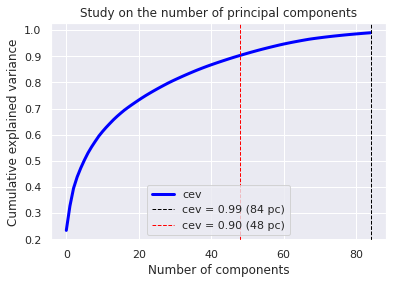

In [12]:
# Let's retrieve the PCA fitted objects from one of our models: since the PCA is computed before the training
# step, the results will be the same for each classifier
PCA_fitted = svm_cc.clf.best_estimator_['pca']

cev = np.cumsum(PCA_fitted.explained_variance_ratio_)
plt.plot(cev, color='blue', lw=3, label='cev')

# Let's plot some typical thresholds
plt.axvline(np.argmax(cev>0.99), ls='--', c='black', lw=1, label='cev = 0.99 ({} pc)'.format(np.argmax(cev>0.99)))
plt.axvline(np.argmax(cev>0.90), ls='--', c='red', lw=1, label='cev = 0.90 ({} pc)'.format(np.argmax(cev>0.90)))

plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Study on the number of principal components')
plt.legend()

See? You can potentially keep the 90% of the information stored in your features with just 48 values! <br>
The accuracies plot in the previous section has been computed keeping, by default, the 99% of the explained variance, i.e. 84 principal components. And the results are still quite nice. What would happen, instead, further reducing the number of eigenvalues to keep?

In [ ]:
def test_models_principal_component(features, n_components, pRF={}, pMLP={}, pKNC={}, pSVM={}):
    accuracies = {}
    training_times = {}
    
    start = time.time()
    rf = ClipsClassifier(dataset=features).Setup_Classifier(pca_components=n_components, verbose=0)
    rf.Run_Nested_Cross_Validation(model=RandomForestClassifier(), parameters=pRF)
    accuracies['RF'] = [np.mean(rf.nested_scores)]
    training_times['RF'] = [time.time() - start]
    
    start = time.time()
    mlp = ClipsClassifier(dataset=features).Setup_Classifier(pca_components=n_components, verbose=0)
    mlp.Run_Nested_Cross_Validation(model=MLPClassifier(), parameters=pMLP)
    accuracies['MLP'] = [np.mean(mlp.nested_scores)]
    training_times['MLP'] = [time.time() - start]
    
    start = time.time()
    knc = ClipsClassifier(dataset=features).Setup_Classifier(pca_components=n_components, verbose=0)
    knc.Run_Nested_Cross_Validation(model=KNeighborsClassifier(), parameters=pKNC)
    accuracies['KNC'] = [np.mean(knc.nested_scores)]
    training_times['KNC'] = [time.time() - start]
    
    start = time.time()
    svm = ClipsClassifier(dataset=features).Setup_Classifier(pca_components=n_components, verbose=0)
    svm.Run_Nested_Cross_Validation(model=SVC(), parameters=pSVM)
    accuracies['SVM'] = [np.mean(svm.nested_scores)]
    training_times['SVM'] = [time.time() - start]
    
    return accuracies, training_times

In [ ]:
# Take the best set of hyperparameters according to the previous analysis
bestp_RF  = {key : [value] for key, value in  rf_cc.clf.best_params_.items()}
bestp_MLP = {key : [value] for key, value in mlp_cc.clf.best_params_.items()}
bestp_KNC = {key : [value] for key, value in knc_cc.clf.best_params_.items()}
bestp_SVM = {key : [value] for key, value in svm_cc.clf.best_params_.items()}

acc_vs_comp = pd.DataFrame()
time_vs_comp = pd.DataFrame()
component_list = [1, 5, 10, 20, 35, 50, 75, 100, 110]

for n_components in tqdm(component_list):
    
    acc, times = test_models_principal_component(features, n_components, pRF, pMLP, pKNC, pSVM)
    acc_vs_comp = pd.concat([acc_vs_comp, pd.DataFrame(acc)])
    time_vs_comp = pd.concat([time_vs_comp, pd.DataFrame(times)])
    
acc_vs_comp['Components'] = component_list
time_vs_comp['Components'] = component_list

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

sns.lineplot(x='Components', y='RF',  data=acc_vs_comp, ax=axs[0], label='RF')
sns.lineplot(x='Components', y='MLP', data=acc_vs_comp, ax=axs[0], label='MLP')
sns.lineplot(x='Components', y='KNC', data=acc_vs_comp, ax=axs[0], label='KNC')
sns.lineplot(x='Components', y='SVM', data=acc_vs_comp, ax=axs[0], label='SVM')
axs[0].set_title('Performances versus PCA')
axs[0].set_xlabel('Principal Components kept')
axs[0].set_ylabel('Mean Accuracy of the models')
axs[0].legend()

sns.lineplot(x='Components', y='RF',  data=time_vs_comp, ax=axs[1], label='RF')
sns.lineplot(x='Components', y='MLP', data=time_vs_comp, ax=axs[1], label='MLP')
sns.lineplot(x='Components', y='KNC', data=time_vs_comp, ax=axs[1], label='KNC')
sns.lineplot(x='Components', y='SVM', data=time_vs_comp, ax=axs[1], label='SVM')
axs[1].set_title('Training times versus PCA')
axs[1].set_xlabel('Principal Components kept')
axs[1].set_ylabel('Training times of the models')
axs[1].legend();

The results looks exactly what we expected.
* The right plot shows the computational times: the bigger are the input vectors, the larger will be the time necessary to make the classifier training on them. With just 2000 clips the absolute difference is not so relevant, but the scaling behavior of the lines, instead, is evident.
* In the left plot we can look at the mean accuracies obtained for our models: after 40/50 principal components the lines start becoming flat, meaning that no significant further improvements are possible. And this is coherent with the explained variance ratio shown in the plot above. The reason for this can maybe be reconduce to the first notebook, and the high number of features that we computed in order to construct a representation for our clips: probably we exaggerated taking as many (55) different values, and only half of them were sufficient. However now, at the training step, once you have already constructed your features dataframe, this does not matter anymore, since you can just reduce the number of principal components setting the proper parameter in the classifier class, to reduce the dimensionality of the input for the models.

### Importance of the statistical estimators of the features distributions

One of the datasets that we have created previously is called *reduced_features.csv*, and the main difference with respect to the data used in the previous section is that, in order to summarize the various distributions of the *features per frame*, identified and collected in the first notebook, we used only their *mean*, without caring of the *standard deviation*. In this way, the "vectors of features" so created will be of size (55,) rather than (110,), leading to a much smaller dataset; but will this influence the final performances of the classifiers?

In [ ]:
red_feat_rf = ClipsClassifier(dataset=reduced_features).Setup_Classifier(verbose=0)
red_feat_rf.Run_Nested_Cross_Validation(model=RandomForestClassifier(), parameters=params_RF)

red_feat_mlp = ClipsClassifier(dataset=reduced_features).Setup_Classifier(verbose=0)
red_feat_mlp.Run_Nested_Cross_Validation(model=MLPClassifier(), parameters=params_MLP)

red_feat_knc = ClipsClassifier(dataset=reduced_features).Setup_Classifier(verbose=0)
red_feat_knc.Run_Nested_Cross_Validation(model=KNeighborsClassifier(), parameters=params_KNC)

red_feat_svm = ClipsClassifier(dataset=reduced_features).Setup_Classifier(verbose=0)
red_feat_svm.Run_Nested_Cross_Validation(model=SVC(), parameters=params_SVM)

In [ ]:
red_features_accuracies_df = pd.DataFrame()
red_features_accuracies_df['red_RF']  = red_feat_rf.nested_scores
red_features_accuracies_df['red_MLP'] = red_feat_mlp.nested_scores
red_features_accuracies_df['red_KNC'] = red_feat_knc.nested_scores
red_features_accuracies_df['red_SVM'] = red_feat_svm.nested_scores

print('Scores of the models over the cross validation folds:')
display(red_features_accuracies_df)

fig, ax = plt.subplots(1, 1, figsize=(16,5))
sns.violinplot(data=pd.concat([red_features_accuracies_df, features_accuracies_df]), ax=ax)
ax.axvline(3.5, ls='--', c='black')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of different models for different statistical estimators', fontsize=18)
ax.set_xticklabels(['RF', 'MLP', 'KNC', 'SVM', 'RF', 'MLP', 'KNC', 'SVM'])

ax.text(1, 0.6, 'Models trained over the dataset \n "reduced_features.csv"', ha="center", va="center", size=15, 
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
ax.text(6, 0.25, 'Models trained over the dataset \n "features.csv"', ha="center", va="center", size=15, 
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9));

The improvement is obvious: using both the mean and the standard deviation as statistics estimators of the features distributions provides almost a +20% to the accuracy obtained with **all** the models used. The explanation has already been shown in the first notebook, giving a direct look at the interested plots; most of the times, in fact, such distributions are quite asymmetric and non-gaussian and taking just the average is probably just an excess of reductionism.

### Importance of the silence removal step

Another version of the feature dataset is _features_nosilenceremoval.csv_. Such dataset has been created computing the mean and the standard deviation of the features distributions, but without the preprocessing step during which we removed fixed size (of 0.5 seconds) windows of continuous silence. During the analysis we observed that in short sounds the impact of this silent part was strong, in the sense that, looking at the distributions of many features, the column corresponding to the value 0 was too much high respect what it was supposed to. So we justified theoretically this additional preprocessing, but from the point of view of a classifier, does this change anything?

In [ ]:
silent_feat_rf = ClipsClassifier(dataset=features_nosilenceremoval).Setup_Classifier(verbose=0)
silent_feat_rf.Run_Nested_Cross_Validation(model=RandomForestClassifier(), parameters=params_RF)

silent_feat_mlp = ClipsClassifier(dataset=features_nosilenceremoval).Setup_Classifier(verbose=0)
silent_feat_mlp.Run_Nested_Cross_Validation(model=MLPClassifier(), parameters=params_MLP)

silent_feat_knc = ClipsClassifier(dataset=features_nosilenceremoval).Setup_Classifier(verbose=0)
silent_feat_knc.Run_Nested_Cross_Validation(model=KNeighborsClassifier(), parameters=params_KNC)

silent_feat_svm = ClipsClassifier(dataset=features_nosilenceremoval).Setup_Classifier(verbose=0)
silent_feat_svm.Run_Nested_Cross_Validation(model=SVC(), parameters=params_SVM)

In [ ]:
silent_features_accuracies_df = pd.DataFrame()
silent_features_accuracies_df['silent_RF']  = silent_feat_rf.nested_scores
silent_features_accuracies_df['silent_MLP'] = silent_feat_mlp.nested_scores
silent_features_accuracies_df['silent_KNC'] = silent_feat_knc.nested_scores
silent_features_accuracies_df['silent_SVM'] = silent_feat_svm.nested_scores

print('Scores of the models over the cross validation folds:')
display(silent_features_accuracies_df)

fig, ax = plt.subplots(1, 1, figsize=(16,5))
sns.violinplot(data=pd.concat([silent_features_accuracies_df, features_accuracies_df]), ax=ax)
ax.axvline(3.5, ls='--', c='black')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of different models without and with silence removal', fontsize=18)
ax.set_xticklabels(['RF', 'MLP', 'KNC', 'SVM', 'RF', 'MLP', 'KNC', 'SVM'])

ax.text(1, 0.34, 'Models trained over the dataset \n "features_nosilenceremoval.csv"', ha="center", va="center", size=15, 
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
ax.text(5.5, 0.34, 'Models trained over the dataset \n "features.csv"', ha="center", va="center", size=15, 
        bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9));

The "features" dataset appear to perform slightly better, let's see how much.

In [ ]:
improvements = pd.DataFrame(columns=['RF', 'MLP', 'KNC', 'SVM'])
improvements.loc[0] = (np.array(features_accuracies_df.mean()) - np.array(silent_features_accuracies_df.mean()))
ax = sns.barplot(data=improvements)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy improvements after silence removal');

And this is not even bad: getting a +3%/+5% improvement in accuracy is nice, at the expenses of a small further preprocessing step.

### Overfitting

The main problem encountered so far is the dimension of the dataset, since with just 2000 clips it is difficult to obtain a significative statistics for the results. In order to avoid creating both a test and a validation sets, that would further reduce the data available for training, we relied on a nested cross validation, as explained before. But how can we be sure that this is enough to eliminate the possibility of overfitting? <br>
To show this we will procede along an additional analysis using a neural network and this time defining a validation set. This won't be realized as before, instantiating the class _ClipsClassifier_ and tuning a set of hyperparameters, because we are not interested in the effective final accuracy of the model, but on the behavior of the loss as the training proceed.

In [13]:
# Define a function that construct a Feed Forward Network with some specified setup
def FFNN(optimizer='adamax', dropout_prob=0.1, lr=0.01):
    
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(1024))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())
    model.add(tf.keras.layers.Dense(512))
    model.add(tf.keras.layers.Dropout(dropout_prob))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.001))
    model.add(tf.keras.layers.PReLU())

    # For stability reason, the softmax will be eventually applied after
    model.add(tf.keras.layers.Dense(50))

    if optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer == 'adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
        
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [ ]:
# Shuffle the dataset
df_nn = features.copy()
df_nn = df_nn.sample(frac=1).reset_index(drop=True)

# Since we won't rely on the pipeline we need to preprocess the data directly here
X = df_nn.drop(['label'], axis=1)
Y = df_nn[['label']].to_numpy()     

# Standardize and use one-hot-encoding
X = StandardScaler().fit_transform(X)
Y = OneHotEncoder(sparse=False).fit_transform(Y)

# Take some reasonable parameters for the network
model = FFNN(optimizer='adamax', dropout_prob=0.5, lr=0.0005)

# Use the 20% of data as validation set
history = model.fit(X, Y, epochs=200, batch_size=128, verbose=0, callbacks=[TqdmCallback(verbose=1)], validation_split=0.2)

In [ ]:
model.summary()

The reason of not proceeding like for the other models is the possibilty offered by _keras_ of having an __history__ object.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
history_df = pd.DataFrame(history.history).copy().reset_index()

sns.lineplot(x='index', y='loss', data=history_df, color='blue', ax=ax[0], label='Training Loss')
sns.lineplot(x='index', y='val_loss', data=history_df, color='red', ax=ax[0], label='Validation Loss')
ax[0].set_title('Analysis of the loss for the FFNN over the "features" dataset')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (Categorical Cross-Entropy)')
ax[0].legend()

sns.lineplot(x='index', y='accuracy', data=history_df, color='blue', ax=ax[1], label='Training Accuracy')
sns.lineplot(x='index', y='val_accuracy', data=history_df, color='red', ax=ax[1], label='Validation Accuracy')
ax[1].set_title('Analysis of the accuracy for the FFNN over the "features" dataset')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend();

This is obviously overfitting: an __early stopping__ condition should be required. <br>
Differently from the previous cases, this time we are considering a validation set that is completely made by _unseen_ data that do not influence the training procedure, so the final accuracy value will be more credible, at least from a statistical point of view. We clearly see from the plot, that already after some epochs, the training accuracy (and also the error) tends to converge to the "perfect" classification, while the generalization error, that in our case is computed in the validation set (400 clips) converges to an accuracy around the 60/70% (depending on the architecture used). <br>
All of this means that the results obtained via nested cross validation are presumably correct, and so that one is a nice and functional approach when dealing with so small amount of data. But this is still not enough. Even using nested cross validation, the overfitting has been reduced, but not completely eliminated.

To conclude this part, let's tune the parameters with a nested cross validation also for our neural network.

In [14]:
params_NN = {'classifier__epochs':[150], 'classifier__batch_size':[64, 128], 
             'classifier__optimizer':['adam', 'adamax'], 'classifier__lr':[0.01, 0.001], 
             'classifier__dropout_prob':[0.1, 0.5]}

params_NN = {'classifier__epochs': [150], 'classifier__batch_size': [128], 'classifier__optimizer': ['adamax'],
             'classifier__lr': [0.0005], 'classifier__dropout_prob':[0.1]}

_Interesting note: apparently, just changing the optimizer from __adam__ to __adamax__ leads to a strong accuracy improvement for some architectures! This could be an aspect deserving to be studied more in depth._

In [15]:
NN = KerasClassifier(build_fn=FFNN, verbose=0)

nn_cc = ClipsClassifier(features).Setup_Classifier(encoder_method='onehot')
nn_cc.Run_Nested_Cross_Validation(model=NN, parameters=params_NN, compute_confusion_matrix=True)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Optimal set of hyperparameters: 
{'classifier__batch_size': 128, 'classifier__dropout_prob': 0.1, 'classifier__epochs': 150, 'classifier__lr': 0.0005, 'classifier__optimizer': 'adamax'}
Average final accuracy estimated: 68.8%


In [16]:
esc50_final_models['NN'] = nn_cc

### Data Augmentation

An important part of our analysis lies in the dataset _augmented_features*.csv_. Such datasets has been created in the first notebook, simply iterating over the clips, and for each of them creating 4 new "augmented" versions with different approaches (noise addiction, time shifting, pitch shifting and time stretching). In this way, instead of 2000 clips we end up with 10000 clips, much more reasonable to construct a reliable statistics. This kind of augmentation has not been "invented" by ourselves, but comes from several papers that faced the same problem, and apparently solved thank to this approach. Of course their methods were different, so we are not yet sure that they'll work also for us.

Let's now repeat the previous analysis for the new dataset: this time an additional precaution is needed, since, when performing a (Stratified)Kfold on our data, we need all the augmented versions of a clip to be in its same fold, otherwise you would have information leakage among the groups created and so you would overfit the dataset. <br>
For this reason, we will write a new _ad hoc_ function, that still exploit some functionalities defined in the class _ClipsClassifier_.

In [17]:
def CrossValidation_withAugmentation(non_augmented_CC, augmented_dataset, model, params):
    """With the augmented vectors, the training procedure is a bit more complex, since you have to force all the
    augmented versions of a clip to be always in the same fold of the original sound."""
    
    X = augmented_dataset.drop(['label', 'clipname'], axis=1)
    Y = augmented_dataset[['label']].to_numpy()    
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(non_augmented_CC.X, non_augmented_CC.Y)

    # Group clips and relative augmentations in the same Stratified folds
    cv_indices = []
    for train_idxs, val_idxs in skf:
        
        train_clips = non_augmented_CC.dataset.loc[train_idxs]['clipname']
        val_clips   = non_augmented_CC.dataset.loc[val_idxs]['clipname']
        
        augmented_train_clips = np.array(augmented_dataset[augmented_dataset['clipname'].isin(train_clips)].index)
        augmented_val_clips   = np.array(augmented_dataset[augmented_dataset['clipname'].isin(val_clips)].index)
        
        np.random.shuffle(augmented_train_clips)
        np.random.shuffle(augmented_val_clips)
        
        cv_indices.append( (augmented_train_clips, augmented_val_clips) )    
        
        
    # Let's borrow a pipeline pbject from the instance of the class ClipsClassifier
    # Standardize and eventually apply pca on the dataset
    pipeline = non_augmented_CC._Create_Pipeline(model)
    
    # Encode the labels
    labels = non_augmented_CC.label_encoder.fit_transform(Y)
    
    GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=non_augmented_CC.n_jobs,
                 verbose=non_augmented_CC.verbose, cv=cv_indices).fit(X, labels)
        
        
    # Fit and evaluate the pipeline    
    cv_scores = cross_val_score(pipeline, X=X, y=labels, n_jobs=non_augmented_CC.n_jobs, 
                                verbose=non_augmented_CC.verbose, cv=cv_indices)
        
    return cv_scores

In [19]:
RF_augscores = CrossValidation_withAugmentation(ClipsClassifier(dataset=features), augmented_features, 
                                                RandomForestClassifier(), params_RF)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   15.4s remaining:   23.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   17.8s finished


In [21]:
MLP_augscores = CrossValidation_withAugmentation(ClipsClassifier(dataset=features), augmented_features, 
                                                 MLPClassifier(), params_MLP)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   18.2s remaining:   27.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.1s finished


In [20]:
KNC_augscores = CrossValidation_withAugmentation(ClipsClassifier(dataset=features), augmented_features, 
                                                 KNeighborsClassifier(), params_KNC)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


In [22]:
SVM_augscores = CrossValidation_withAugmentation(ClipsClassifier(dataset=features), augmented_features, 
                                                 SVC(), params_SVM)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.2s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


In [27]:
# Saving the final results
aug_esc50_scores = {'RF'  :  RF_augscores, 'MLP' : MLP_augscores, 'KNC' : KNC_augscores, 'SVM' : SVM_augscores}

Before comparing the results, let's consider also, for this time, a gridsearch over a neural network, changing the number of epochs, the optimizer or the learning rate...

In [26]:
NN = KerasClassifier(build_fn=FFNN, verbose=0)

NN_augscores = CrossValidation_withAugmentation(ClipsClassifier(dataset=features).Setup_Classifier(encoder_method='onehot'), 
                                                augmented_features, NN, params_NN)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.3s remaining:   16.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.9s finished


In [28]:
aug_esc50_scores['NN'] = NN_augscores

And now let's see the differences among the nested cross validations with and without the data augmentation procedure that we have implemented in the first notebook.

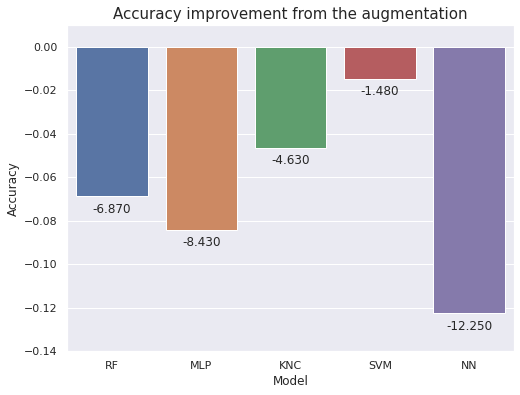

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

relative_accuracies = pd.DataFrame({key : aug_esc50_scores[key].mean()-esc50_final_models[key].final_accuracy 
                       for key in esc50_final_models}.items(), columns=['Model', 'Accuracy Improvement'])

sns.barplot(x='Model', y='Accuracy Improvement', data=relative_accuracies, ax=ax)

for p in ax.patches:
    ax.annotate(format(p.get_height()*100, '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()-0.01), 
                   ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points')

ax.set_ylim(-0.14, 0.01)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy improvement from the augmentation', fontsize=15);

Ok, apparently augmenting our clips leads to a drastical worsening of the performancies of our models. <br>
One reason could be the fact that, summarizing an entire clip with a vector of just 110 values is barely influenced by traditional audio augmentation procedures, maybe because the distributions of some features remain invariant even after the transformation. In this way we would end up just adding copies of the vectors already present in the original dataset, increasing the overfitting. This "theory" has been checked grafually removing augmentation steps, like keeping only noise + time_shif, pitch_shift + time_stretch and so on: in all cases we still obtain worse results than using original data, but we noticed that the worsening is reduced when we consider less augmenting transformations. And this heuristical analysis can be took as an indication that our argument is correct and so canonical audio augmentation procedures are not a good idea when combined with features extraction methods (at least in our case). <br>
We will see if they instead works with convolutional neural networks in the third notebook.

## Best case deeper Analysis

In this second-last section we will take one of the previous models trained over the augmented datasets with an high accuracy, and we will examine its performances deeper and on an higher level. Our choice fell on the neural network.

The first thing that is worth to examine is the confusion matrix of the model. The following plot basically represents the true labels of the whole ESC50 set (2000 samples) versus the predictions of the network, for each of the possible classes of the data. Notice that, since the features have been encoded before being fed to the classifiers, they have been sorted in alphabetical order, and so they are no more grouped in macro-categories.

In [41]:
deeper_analysis_model = nn_cc

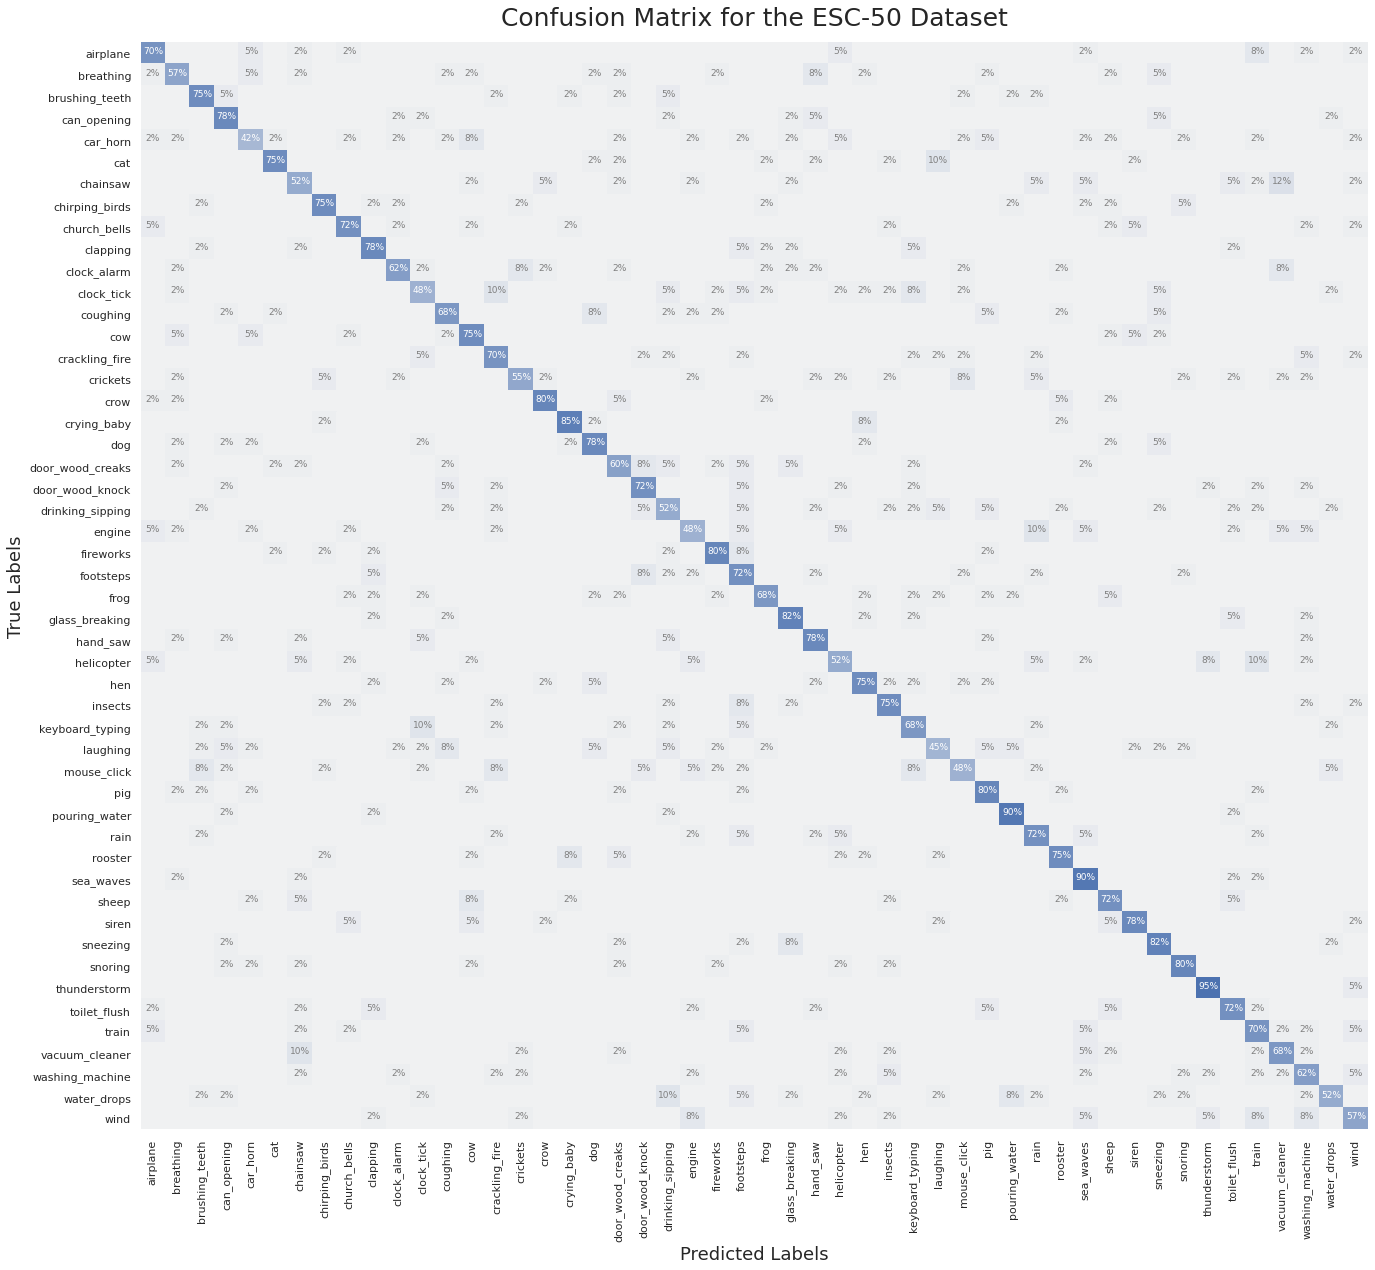

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(22,20))

# Normalize the confusion matrix row by row
row_sums = deeper_analysis_model.confusion_matrix.sum(axis=1)
norm_confmat = (deeper_analysis_model.confusion_matrix/row_sums[:, np.newaxis])

sns.heatmap(norm_confmat, cmap=sns.color_palette("light:b", as_cmap=True), ax=ax, cbar=False)

ax.set_title('Confusion Matrix for the ESC-50 Dataset', fontsize=25, y=1.01)
ax.set_xticklabels(deeper_analysis_model.label_encoder.categories_[0], rotation=90)
ax.set_yticklabels(deeper_analysis_model.label_encoder.categories_[0], rotation=0)
ax.set_xlabel('Predicted Labels', fontsize=18)
ax.set_ylabel('True Labels', fontsize=18)

for x in range(50):
    for y in range(50):
        if norm_confmat[y, x] != 0:
            if x==y: c = 'white'
            else: c = 'grey'
            ax.text(x+0.5, y+0.5, "{:.0%}".format(norm_confmat[y, x]), fontsize=9, ha='center', color=c)

In [ ]:
# Save for future purposes
np.savetxt('ConfusionMatrix_feature_classification.txt', norm_confmat, fmt='%.3f')

But, is there a way to check how our model behave from the point of view of the different macro-categories? <br>
Well, yeah. We just need to take the previous confusion matrix, and summing up, for each row, all the entries that correspond to the columns belonging to the same macro area. Obviously, since, as said, the classes are sorted in alphabetical order, we need to construct a specific function to group them again.

In [43]:
def compute_macro_conf_mat(confusion_matrix):
    """Given the confusion matrix for the 50 classes, this function return the corresponding mapped confusion 
    matrix of the macro-categories."""
    
    macro_confusion_matrix = np.zeros((5,5))
    
    # Map micro into macro categories
    animals  = [5, 13, 16, 18, 25, 29, 30, 34, 37, 39]
    natural  = [7, 14, 15, 35, 36, 38, 43, 44, 48, 49]
    humans   = [1, 2,   9, 12, 17, 21, 24, 32, 41, 42]
    domestic = [3, 10, 11, 19, 20, 26, 31, 33, 46, 47]
    urban    = [0, 4,   6,  8, 22, 23, 27, 28, 40, 45]
    
    macro_categories = [animals, natural, humans, domestic, urban]
    
    for i in range(5):
        for j in range(5):
            for cat in macro_categories[j]:
                macro_confusion_matrix[i,j] += sum(confusion_matrix[macro_categories[i], cat])

    return macro_confusion_matrix
        
macro_confusion_matrix = compute_macro_conf_mat(deeper_analysis_model.confusion_matrix)
macro_confusion_matrix

array([[330.,   7.,  29.,  15.,  19.],
       [ 10., 318.,  28.,  22.,  22.],
       [ 29.,  12., 310.,  27.,  22.],
       [ 12.,  33.,  32., 301.,  22.],
       [ 22.,  32.,  19.,  25., 302.]])

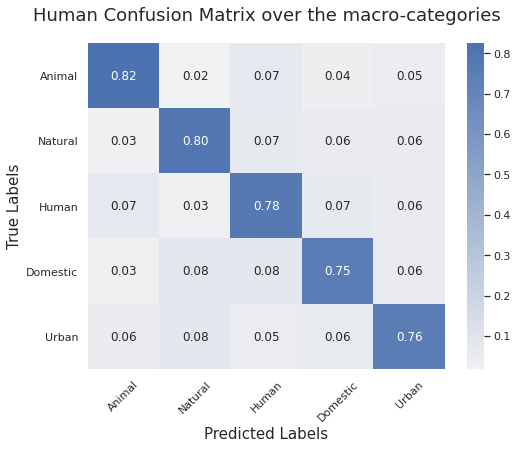

In [44]:
macro_categories = ['Animal', 'Natural', 'Human', 'Domestic', 'Urban']

# Normalize the confusion matrix row by row
row_sums = macro_confusion_matrix.sum(axis=1)
norm_conf_macro = macro_confusion_matrix/row_sums[:, np.newaxis]

fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(norm_conf_macro, cmap=sns.color_palette("light:b", as_cmap=True), annot=True, fmt='.2f', ax=ax)
ax.set_title('Human Confusion Matrix over the macro-categories', fontsize=18, y=1.05)
ax.set_xticklabels(macro_categories, rotation=45)
ax.set_yticklabels(macro_categories, rotation=0)

ax.set_xlabel('Predicted Labels', fontsize=15)
ax.set_ylabel('True Labels', fontsize=15);

### Example of functionality

Let's take a random sample from the dataset and see how the model behave. <br>

We will use some 3D utility functions from matplotlib explained [here](https://gist.github.com/WetHat/1d6cd0f7309535311a539b42cccca89c).

In [45]:
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch

# Define a class to handle 3D arrows
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
        
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''

    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)

setattr(Axes3D,'arrow3D',_arrow3D)

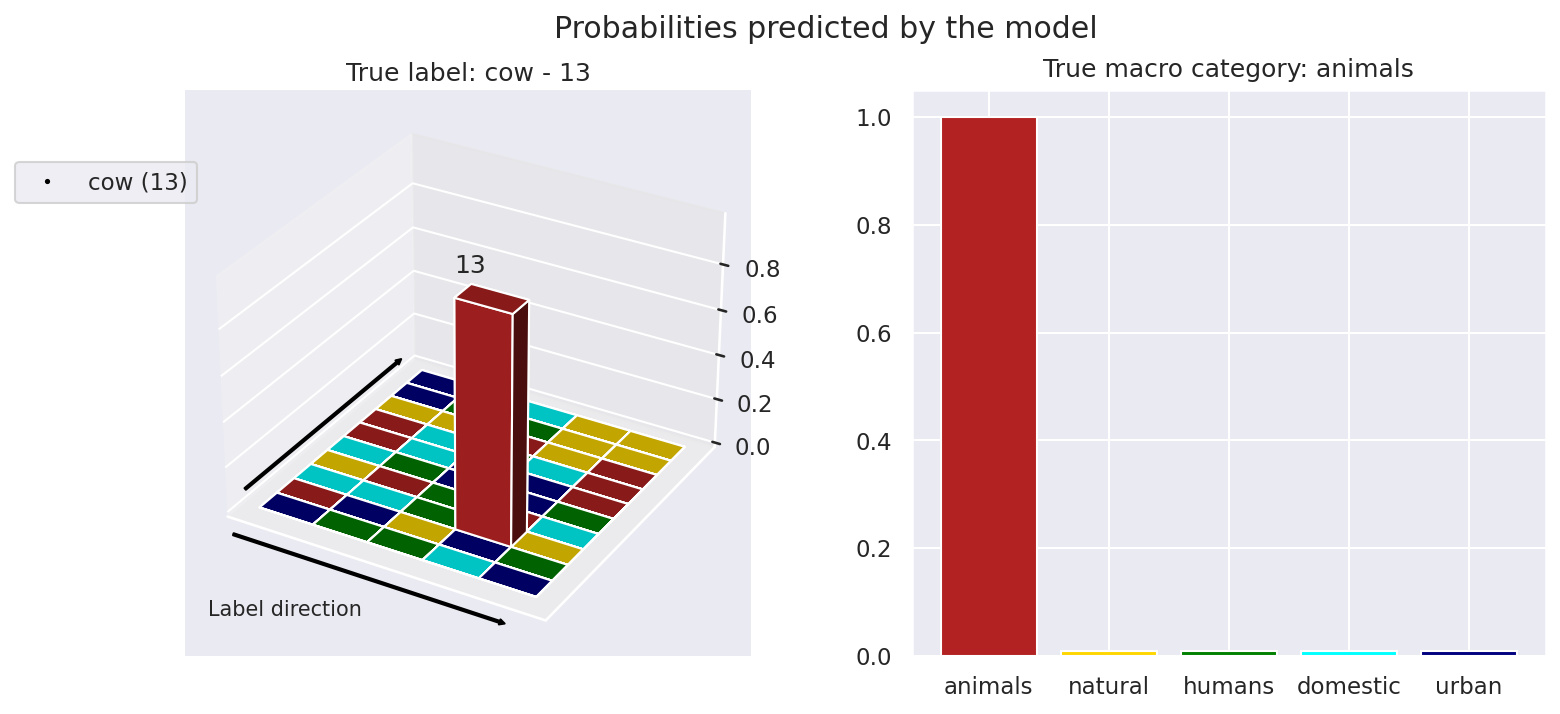

In [50]:
def DisplayPrediction(sample, CC):
    """Give a visual representation of the probabilities predicted by our model.
    The function takes in input a dataframe like the rows in our csv files, and a fitted instance
    of the class ClipsClassifier. Actually, it works only with neural networks because they allow
    us to predict an entire vector of probabilities."""
    
    

    # Extract the vector of features and the label
    features = sample.drop(['label', 'clipname'], axis=1)
    true_label = sample['label'][sample.index[0]]

    # Convert the label to categorical and one-hot encoding
    true_label_onehot = CC.label_encoder.transform([[true_label]])
    true_label_cat = np.argmax(true_label_onehot, axis=1)[0]
    
    # Compute the predictions according to the model fitted
    predictions = tf.nn.softmax(CC.clf.predict_proba(features).flatten()).numpy()

    fig = plt.figure(figsize=(12, 5), dpi=150)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122)

    fig.suptitle('Probabilities predicted by the model')
    ax1.set_title('True label: {0} - {1}'.format(true_label, true_label_cat), y=1.08)

    xx, yy = np.meshgrid(np.arange(5), np.arange(10), copy=False)
    dx = 1
    dy = 1
    dz = predictions

    # Construct a proper colomap to distinguish macro-categories
    animals  = [5, 13, 16, 18, 25, 29, 30, 34, 37, 39]
    natural  = [7, 14, 15, 35, 36, 38, 43, 44, 48, 49]
    humans   = [1, 2,   9, 12, 17, 21, 24, 32, 41, 42]
    domestic = [3, 10, 11, 19, 20, 26, 31, 33, 46, 47]
    urban    = [0, 4,   6,  8, 22, 23, 27, 28, 40, 45]
    
    colors = ['firebrick', 'gold', 'green', 'aqua', 'navy']
    macro  = ['animals', 'natural', 'humans', 'domestic', 'urban']
    
    for cat, idxs in zip(macro, [animals, natural, humans, domestic, urban]):
        if true_label_cat in idxs: true_macro_cat = cat

    colormap = np.empty(50, dtype='U10')
    for (col, idx) in zip(colors, [animals, natural, humans, domestic, urban]):
        colormap[idx] = col

    handles = []
    for pos, proba in enumerate(predictions):
        # Write every contribution bigger than the 1%
        if proba > 0.01: 
            # Convert label
            clip_class = CC.label_encoder.categories_[0][pos]
            handles.append(mlines.Line2D([], [], color='black', marker='.', linestyle='None', markersize=3, 
                                         label=clip_class + ' ({})'.format(pos)))
            ax1.text(xx.ravel()[pos], yy.ravel()[pos], proba + .1, pos )


    ax1.bar3d(xx.ravel(), yy.ravel(), dz*0, dx, dy, dz, color=colormap)
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    ax1.arrow3D(0,-1.7,0, 5,0,0, mutation_scale=5, ec='black', fc='black')
    ax1.arrow3D(-0.5,0.5,0, 0,10,0, mutation_scale=5, ec='black', fc='black')
    ax1.text(1,-5.8,0, 'Label direction', fontsize=10)
    
    ax1.legend(handles=handles, loc=(-0.3,0.8))
    
    
    macro_pred = np.array([sum(predictions[mapping]) for mapping in [animals, natural, humans, domestic, urban]])
    macro_pred[macro_pred < 0.01] = 0.01
    
    
    ax2.bar(x=macro, height=macro_pred, color=colors)
    ax2.set_title('True macro category: ' + true_macro_cat)

    plt.show()
            

DisplayPrediction(sample=features.sample(1), CC=deeper_analysis_model)

Running several times the function with different random samples, we notice that most of the time there is a unique high column representing the prediction of the network; this means that, in most of the cases, the model is quite __sure__ about which class the considered set of features belongs to, without any doubt. And this happens also for missclassified samples, in which there are at most 2 or 3 smaller columns, none of them corresponding to the true labels.

Let's take a sample from the class that, according to the confusion matrix, our network fails to classify most of the times, i.e. -----.

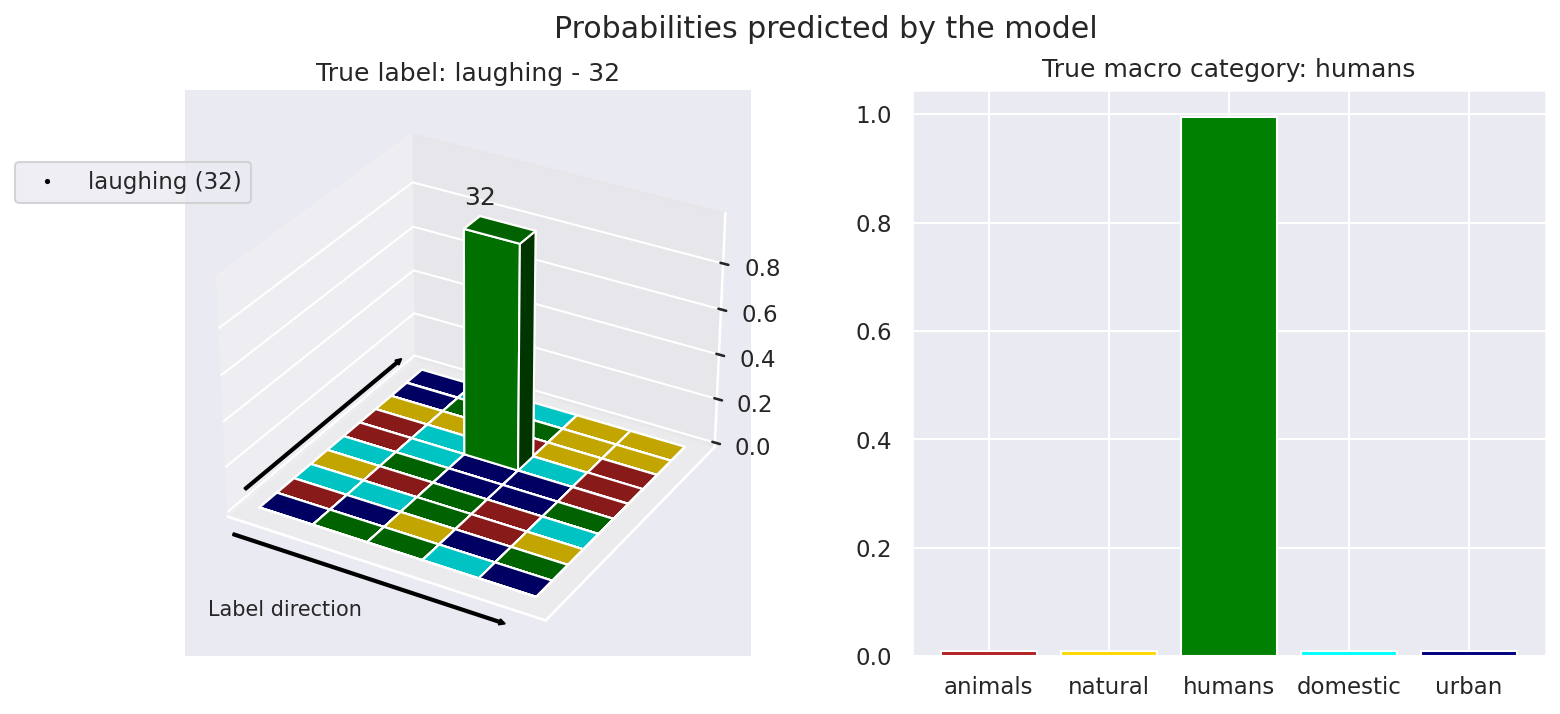

In [154]:
DisplayPrediction(sample=features[features['label']=='laughing'].sample(1), CC=deeper_analysis_model)

## Comprehensive recap of all the results

As final check over our work, it is worth to examine the effective final performances of all the models that we have trained over the classes of environmental sounds of the ESC-50 dataset. In particular we will check two statistical estimators, that are the __accuracy__, i.e. the fraction of relevan instances among the retrieved ones, and the __recall__ (or __sensitivity__), that instead is the fraction of relevant instances that were retrieved. From a practical point of view we can calculate:

$$
accuracy = \frac{\text{true positives}}{\text{true positives + false positives}} \qquad\qquad
recall = \frac{\text{true positives}}{\text{true positives + false negatives}}
$$

The first one is stored as a value in the class instances while the second can be computed from the confusion matrices.

In [137]:
def Add_Classifier_Recall(confusion_matrix, model_name, marker, color, ax):
    """"""
    # Normalize the confusion matrix row by row
    row_sums = confusion_matrix.sum(axis=1)
    norm_conf_mat = confusion_matrix/row_sums[:, np.newaxis]
    
    recall_values = np.array([norm_conf_mat[idx, idx] for idx in range(norm_conf_mat.shape[0])])
                                                                                           
    # Reverse the array to coincide with the alphabetical order of the plot
    ax.scatter(x=recall_values[::-1], y=np.arange(50), label=model_name, marker=marker, color=color, s=40, alpha=0.8)

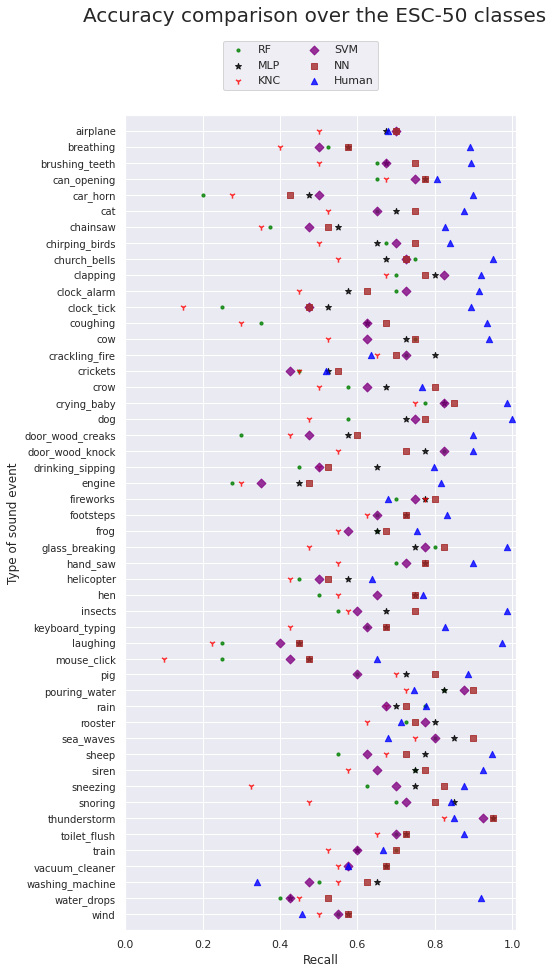

In [152]:
fig, ax = plt.subplots(1,1,figsize=(7,15))
fig.suptitle('Accuracy comparison over the ESC-50 classes', fontsize=20)

# Load human classification accuracy
human_accuracy = pd.read_csv(os.getcwd() + '/ESC-50-master/ESC-50-master/esc50_confusion_matrix.csv', header=None)
human_accuracy = human_accuracy.replace(to_replace='\xa0', value=0).astype(np.int32)

# Add the recall points in the plot
markers = ['.', '*', '1', 'D', 's']
cols = ['green', 'black', 'red', 'purple', 'brown']
for i, key in enumerate(esc50_final_models):
    Add_Classifier_Recall(esc50_final_models[key].confusion_matrix, model_name=key, marker=markers[i], 
                          color=cols[i], ax=ax)

Add_Classifier_Recall(np.array(human_accuracy), model_name='Human', marker='^', color='blue', ax=ax)


ax.set_ylim((-1, 50))
ax.set_yticks(range(0, 50))
ax.set_yticklabels(np.unique(features.label)[::-1], fontsize=10)
ax.set_xlim((0.0, 1.01))

ax.set_ylabel('Type of sound event')
ax.set_xlabel('Recall')

plt.legend(ncol=2, loc=(0.25,1.03));

To avoid too much confusion we decided to plot only the models trained with the nested cross-validation over the dataset _features.csv_, and not over the augmented one. <br>
Something that is worth to notice involve the neural network: as we can notice, there are some class that are never predicted by the model. 

In [141]:
# Load the value got form ESC-50
df_acc = pd.DataFrame.from_dict(esc50_final_models.items())
df_acc.columns = ['model', 'accuracy']
df_acc['accuracy'] = df_acc['accuracy'].apply(lambda x: x.final_accuracy)
df_acc['dataset'] = 'ESC-50'
# Add human accuracy
df_acc = df_acc.append({'model':'Human', 'accuracy':0.813, 'dataset':'ESC-50-human'}, ignore_index=True)
# Load values from augmented ESC-50
df_aug_acc = pd.DataFrame.from_dict(aug_esc50_scores.items())
df_aug_acc.columns = ['model', 'accuracy']
df_aug_acc['accuracy'] = df_aug_acc['accuracy'].apply(lambda x: x.mean())
df_aug_acc['dataset'] = 'Augmented ESC-50'
comparison_df = pd.concat([df_acc, df_aug_acc])

comparison_df.sort_values('accuracy', ascending=False, ignore_index=True, inplace=True)

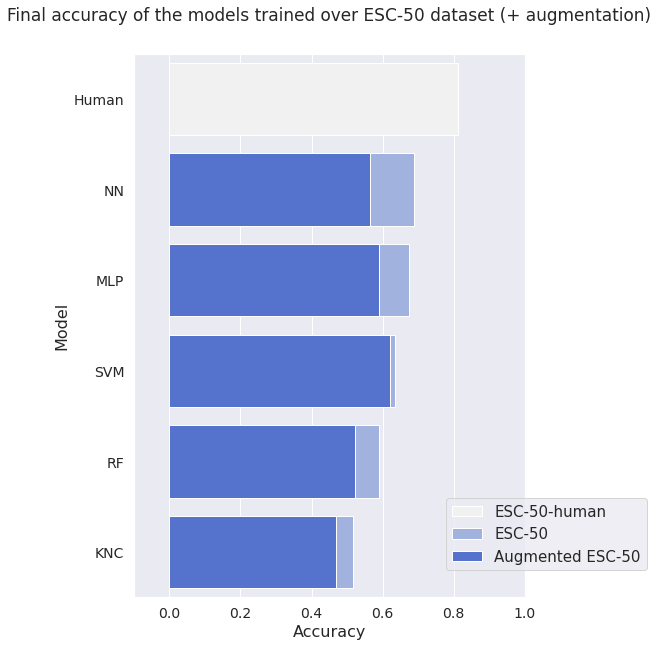

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(7, 10))
ax.set_title('Final accuracy of the models trained over ESC-50 dataset (+ augmentation)', fontsize=17, y=1.05)
ax.set_xlim(-0.1, 1)

sns.barplot(x='accuracy', y='model', hue='dataset', data=comparison_df, color='royalblue', dodge=False)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Accuracy', fontsize=16)
ax.set_ylabel('Model', fontsize=16)
ax.legend(title='', fontsize=15, loc=(0.8,0.05));

Final considerations.

### Further possibilities?

Reading the articles suggested by the author of the dataset, one notice that, in the ranking of the models that perform best on the ESC-50 dataset, all the higher position are occupied by __Convolutional Neural Networks__. In such projects, in fact, a new kind of approach is suggested, and this approach consists into developing several architectures and training procedures based on the direct analysis of the raw spectrograms originated by the clips, rather than on the extraction of several significant features from them. The technique followed in this notebook is for sure better in term of computational times, since each single clip is identified with a vector of just ~100 parameters, rather than an images with thousands of values. The fact is that, apparently, at the expense of a longer training time and memory usage (storing 2000 images is not so cheap from this point of view), you are able to reach better accuracies. <br>
In the next notebook, we will examine those new approaches, developing architectures aimed at sound classification via the analysis of the spectrograms of the clips; we will also check again how data augmentation is able to impact in our training procedure and we will push our models to the limit in order to reach the best accuracy possible (always trying to provide a statistical justification of our choices).